In [32]:
# Import modules
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import os


def work_space(path):
    while True:
        if os.path.split(path)[1] != "Phys117":
            path = os.path.split(path)[0]
        else:
            return path.replace("\\", "/")

work_dir = work_space(os.getcwd())
data_path = work_dir + "/Markus/Hub/VariableData/"
folders = os.listdir(data_path)
data_files = [data_path + data_file for data_file in folders]
stuffs = ["electron", "jet", "MET", "muon", "photon", "tau"]
data_variables = ["met", "HT", "stuff_amount", "ptmax", "phi_diff"]
file_amounts = [2, 18, 3]


def unpacker(folder_data, new_folder_data):
    for nested_list in folder_data:
        if type(nested_list) == list:
            unpacker(nested_list, new_folder_data)
        else:
            new_folder_data.append(nested_list)
    folder_data = new_folder_data
    return folder_data


def efficiencies_data(efficiency_data, binsize):
    bh_data, sphal_data = efficiency_data
    x_bh, y_bh = data_binner(bh_data, binsize, plot = False)
    x_sphal, y_sphal = data_binner(sphal_data, binsize, plot = False)
    x_interval = np.concatenate((x_bh, x_sphal))
    x_min, x_max = np.min(x_interval), np.max(x_interval)
    bins = int(np.round((x_max - x_min)/binsize))
    x = [x_min + (bin + 1)*binsize for bin in range(bins + 1)]
    total_efficiencies = []

    for bin in range(bins + 1):
        bh_left = y_bh[:bin + 1]
        bh_right = y_bh[bin + 1:]
        bh_split = [bh_left, bh_right]
        
        sphal_left = y_sphal[:bin + 1]
        sphal_right = y_sphal[bin + 1:]
        sphal_split = [sphal_right, sphal_left]

        left_efficiencies = []
        right_efficiencies = []
        temp_efficiency = []
        for i in range(len(["left", "right"])):
            bh_efficiency = np.sum(bh_split[i])
            sphal_efficiency = np.sum(sphal_split[i])
            total_efficiency = bh_efficiency + sphal_efficiency
            if i == 0:
                temp_efficiency.append((total_efficiency, "BH < Sphal"))
                left_efficiencies.append((bh_efficiency, sphal_efficiency))
            else:
                temp_efficiency.append((total_efficiency, "BH > Sphal"))
                right_efficiencies.append((bh_efficiency, sphal_efficiency))


        total_efficiencies.append((*sorted(temp_efficiency, key = lambda x: x[0])[-1], bin))
    
    max_efficiency = sorted(total_efficiencies, key = lambda x: x[0])[-1]
    me_value = max_efficiency[0] / 2
    me_dir = max_efficiency[1]
    me_bin = max_efficiency[2]
    me_x = x_min + me_bin * binsize
    
    return [left_efficiencies, right_efficiencies], [me_x, me_value, me_dir]


def data_binner(data, binsize, plot):
    data = unpacker(data, [])

    if len(data) == 0:
        x = [bin * binsize for bin in range(200)]
        y = [0 for bin in range(200)]
        return x, y

    max_value = np.max(data)
    bins = int(np.round(max_value / binsize))
    bins = np.arange(0, bins)
    data = np.array(data)
    x, y = [], []

    if plot:
        for bin in range(len(bins)):
            temp = data
            temp = temp[temp <= (bin + 1/2)*binsize]
            temp = temp[(bin - 1/2)*binsize < temp]
            if len(temp) != 0:
                y.append(len(temp))
                x.append(bin*binsize)

        y = y/np.sum(y)

        return x, y
    else:
        for bin in range(len(bins)):
            temp = data
            temp = temp[temp <= (bin + 1/2)*binsize]
            temp = temp[(bin - 1/2)*binsize < temp]
            y.append(len(temp))
            x.append(bin*binsize)

        y = y/np.sum(y)

        return x, y


def plot_filter(interval_data, filter_strength):
    interval_data = sorted(interval_data)
    cutoff = round((len(interval_data) * filter_strength))
    interval_data = interval_data[:cutoff]
    x_min = np.min(interval_data)
    x_max = np.max(interval_data)
    extra = (x_max - x_min) / 10
    return [x_min - extra, x_max + extra]


def sampler(output_dataframe, output_filenames, file_amounts, combine_data):
    from random import sample

    output_dataframe = [[(dataframe, filename) for dataframe, filename in zip(dataframes, filenames)] for dataframes, filenames in zip(output_dataframe, output_filenames)]
    samples = [sample(dataframes, file_amount) for dataframes, file_amount in zip(output_dataframe, file_amounts)]

    if combine_data:
        output_dataframe = [pd.concat([sample[0] for sample in dataframes]) for dataframes in samples]
        labels = folders
    else:
        output_dataframe = [[sample[0] for sample in dataframes] for dataframes in samples]
        labels = [[sample[1] for sample in dataframes] for dataframes in samples]

    

    return output_dataframe, labels


def plotter(data_variables, dataframes, labels, filter_strengths, binsizes):

    for variable_index, variable in enumerate(data_variables):
        fig = plt.figure()
        style = "seaborn-darkgrid"
        plt.style.use(style)
        title = variable + " Distribution"
        fig.suptitle(title)
        subplots = fig.subplots(1, 2)
        binsize = binsizes[variable_index] if type(binsizes) == list else binsizes
        filter_strength = filter_strengths[variable_index] if type(filter_strengths) == list else filter_strengths
        interval = np.concatenate([dataframe[variable] for dataframe in dataframes])
        xlim = plot_filter(interval, filter_strength)
        plots_data, max_eff = efficiencies_data(dataframes, binsize)
        
        for plot_index, plot_data in enumerate(plots_data):
            ax = subplots[plot_index]
            ax.set_xlim(xlim)
            ax.xlabel(variable)
            ax.ylabel("frequency")
            if plot_index == 0:
                plot_labels = [["efficiencies for " + label + " to the " + direction] for label, direction in zip(labels, ["left", "right"])]
            else:
                plot_labels = [["efficiencies for " + label + " to the " + direction] for label, direction in zip(labels, ["right", "left"])]


            for direction_index, direction in enumerate(["left", "right"]):
                plot_data = plot_data[direction_index]
                label = plot_labels[direction_index]
                ax.plot(data_binner(plot_data, binsize), label)

            ax.legend(prop = {'size': 8})
        
        plt.show()

In [33]:
from FilesFunc import files
folder_list, filename_list = files(data_path, folders, file_amounts)


foldered_dataframes = [[pd.read_csv(data_file).drop("Unnamed: 0", axis = 1) for data_file in folder_files] for folder_files in folder_list]

[          met        HT  stuff_amount    ptmax  phi_diff
0      299.10   5573.07             7  2085.83  2.321000
1      770.31   8951.71             7  2736.08  0.385000
2      628.21   9472.02             9  3357.58  0.278407
3      262.74   7746.55             9  2584.25  1.002000
4      314.69   8945.66            12  3007.03  0.421407
...       ...       ...           ...      ...       ...
9638  1094.92  11490.23             7  5217.32  0.022593
9639   771.78   7671.98             5  2727.45  1.154593
9640  1141.17   7587.03             9  1858.83  1.812593
9641   983.20   8008.29            10  2845.48  0.230593
9642   202.91   7701.18             5  3703.03  1.475000

[9643 rows x 5 columns],           met       HT  stuff_amount    ptmax  phi_diff
0      468.48  5255.88            14  1957.99  2.577000
1       78.00  7869.24             6  3690.35  1.517593
2      495.70  6712.76             7  3282.27  2.778185
3      547.29  5036.98            11  1561.38  1.796593
4       9

UFuncTypeError: ufunc 'maximum' did not contain a loop with signature matching types (dtype('<U12'), dtype('<U12')) -> None

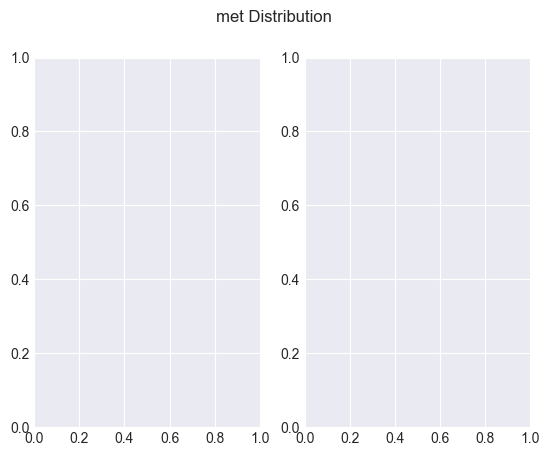

In [34]:
combine_data = False
data_sample, labels = sampler(foldered_dataframes, filename_list, file_amounts = [0, 18, 3], combine_data = combine_data)
print(data_sample[1])
if combine_data:
    plotter(data_variables, data_sample, labels, filter_strengths = [0.95, 0.975, 0.99, 0.95, 1], binsizes = [50, 50, 0.5, 50, 0.2])
else:
    for bh_data, bh_label in zip(data_sample[folders.index("BH")], labels[folders.index("BH")]):
        for sphal_data, sphal_label in zip(data_sample[folders.index("Sphaleron")], labels[folders.index("Sphaleron")]):
            plotter(data_variables, [bh_data, sphal_data], [bh_label, sphal_label], filter_strengths = [0.95, 0.975, 0.99, 0.95, 1], binsizes = [50, 50, 0.5, 50, 0.2])



TypeError: list indices must be integers or slices, not str

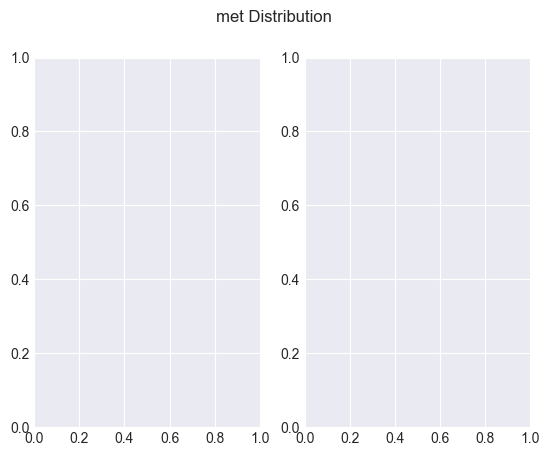

In [ ]:
plotter(data_variables, data_sample, labels, filter_strengths = [0.95, 0.975, 0.99, 0.95, 1], binsizes = [50, 50, 0.5, 50, 0.2])